### Run in collab
<a href="https://colab.research.google.com/github/racousin/data_science_practice/blob/master/website/public/modules/module13/exercise/module13_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install swig==4.2.1
!pip install gymnasium==0.29.1

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# module13_exercise2 : ML - Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a>

### Objective
Get at list an agent running on ML-Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a> with mean reward upper than 0.35 (ie 35%)


You should submit an agent file named `agent.py` with a class `Agent` that includes at least the following attributes:

In [3]:
class Agent:
    def __init__(self, env):
        self.env = env

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = self.env.action_space.sample() # your logic here
        return action

### Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world [7,7].

Holes in the ice are distributed in set locations.

The player makes moves until they reach the goal or fall in a hole.

Each run will consist of 10 attempts to cross the ice. The reward will be the total amount accumulated during those trips. For example, if your agent reaches the goal 3 times out of 10, its reward will be 3.

The environment is based on :

In [4]:
env = gym.make('FrozenLake-v1', map_name="8x8")

Boucle de training

In [5]:
def run_experiment_episode_train(env, agent, nb_episode, is_train=True):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()[0]
        terminated, truncated = False, False
        rews = []
        while not (terminated or truncated):
            action = agent.act(state)
            current_state = state
            state, reward, terminated, truncated, info = env.step(action)
            if is_train:
                agent.train(current_state, action, reward, state, terminated or truncated)
            rews.append(reward)
        rewards[i] = sum(rews)
        #print(f'Episode: {i} - Cumulative Reward: {rewards[i]}')
    return rewards

Différentes policy envisageables

In [6]:
def get_epislon_greedy_action_from_q(Q_s, epsilon):
    if np.random.rand() > epsilon:
        return np.argmax(Q_s)
    else:
        return np.random.randint(len(Q_s))

def get_softmax_action_from_q(Q_s, temperature):
    exp_Q_s = np.exp(Q_s / temperature)
    probs = exp_Q_s / np.sum(exp_Q_s)
    return np.random.choice(len(Q_s), p=probs)

Mes agents suivants les différentes policy considérées

In [7]:
class Agent_epsilon_greedy():
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n)) *0.5

    def act(self, state):
        action = get_epislon_greedy_action_from_q(self.q[state], self.epsilon)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + ( 0 if done else self.gamma * np.max(self.q[next_state]) )
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)


class Agent_Decay():
    def __init__(self, env, gamma = .99, epsilon = .99, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n)) *0.5

    def act(self, state):
        action = get_epislon_greedy_action_from_q(self.q[state], self.epsilon)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + ( 0 if done else self.gamma * np.max(self.q[next_state]) )
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        self.epsilon_decay_exponential()

    def epsilon_decay_exponential(self):
        self.epsilon = max(self.epsilon * 0.99, 0.01)


class Agent_softmax():
    def __init__(self, env, gamma = .99, temperature = .1, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.temperature = temperature
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n)) *0.5

    def act(self, state):
        action = get_softmax_action_from_q(self.q[state], self.temperature)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + ( 0 if done else self.gamma * np.max(self.q[next_state]) )
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)


class Agent_Decay_softmax():
    def __init__(self, env, gamma = .99, temperature = .99, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.temperature = temperature
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n)) *0.5

    def act(self, state):
        action = get_softmax_action_from_q(self.q[state], self.temperature)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + ( 0 if done else self.gamma * np.max(self.q[next_state]) )
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        self.temperature_decay_exponential()

    def temperature_decay_exponential(self):
        self.temperature = max(self.temperature * 0.99, 0.01)


Première phase de training

In [8]:
nb_episode = 5000

my_agent_epsilon_greedy = Agent_epsilon_greedy(env)
rewards_agent_epsilon_greedy = run_experiment_episode_train(env, my_agent_epsilon_greedy, nb_episode)

my_agent_decay = Agent_Decay(env)
rewards_agent_decay = run_experiment_episode_train(env, my_agent_decay, nb_episode)

my_agent_softmax = Agent_softmax(env)
rewards_agent_softmax = run_experiment_episode_train(env, my_agent_softmax, nb_episode)

my_agent_decay_softmax = Agent_Decay_softmax(env)
rewards_agent_decay_softmax = run_experiment_episode_train(env, my_agent_decay_softmax, nb_episode)

Visualisation

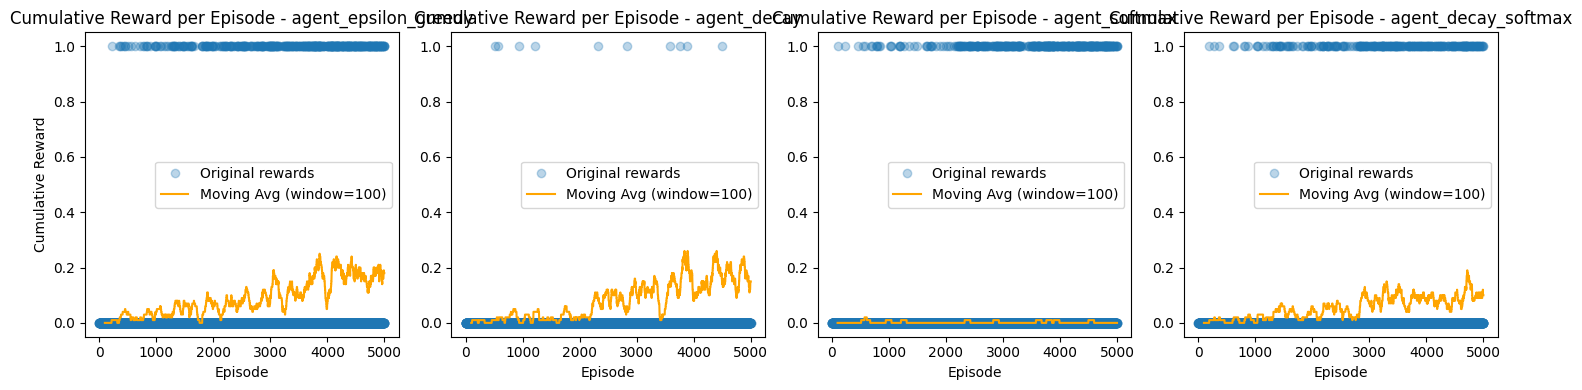

In [9]:
# Compute the moving average with a window size of 100
window_size = 100
moving_avg = np.convolve(rewards_agent_epsilon_greedy, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_agent_decay, np.ones(window_size) / window_size, mode='valid')
moving_avg_softmax = np.convolve(rewards_agent_softmax, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay_softmax = np.convolve(rewards_agent_decay_softmax, np.ones(window_size) / window_size, mode='valid')

# Plot with subplots
plt.figure(figsize=(15, 4))

# First subplot: Original rewards with moving average for agent
plt.subplot(1, 4, 1)
plt.plot(rewards_agent_epsilon_greedy, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent_epsilon_greedy)), moving_avg, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_epsilon_greedy')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

# Second subplot: Original rewards with moving average for decay_agent
plt.subplot(1, 4, 2)
plt.plot(rewards_agent_softmax, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent_decay)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_decay')
plt.xlabel('Episode')
plt.legend()

# Third subplot
plt.subplot(1, 4, 3)
plt.plot(rewards_agent_decay, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent_softmax)), moving_avg_softmax, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_softmax')
plt.xlabel('Episode')
plt.legend()

# Fourth subplot
plt.subplot(1, 4, 4)
plt.plot(rewards_agent_decay_softmax, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent_decay_softmax)), moving_avg_decay_softmax, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_decay_softmax')
plt.xlabel('Episode')
plt.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

Tests pour différents paramètres

In [10]:
nb_episode = 5000

cmap = plt.get_cmap('jet_r')

gamma = .99

(pour epsilon greedy)

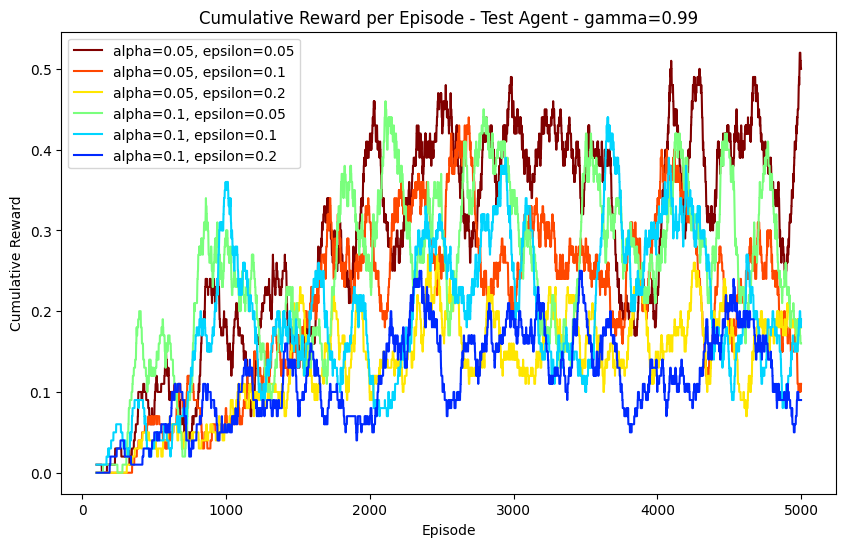

In [11]:
alphas = [.05, .1]
epsilons = [.05, .1, .2]
N=len(alphas)*len(epsilons)

plt.figure(figsize=(10, 6))
i=0

for alpha in alphas:
      for epsilon in epsilons:
            test_agent = Agent_epsilon_greedy(env, gamma, epsilon, alpha)
            rewards = run_experiment_episode_train(env, test_agent, nb_episode)
            window_size = 100
            moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
            color = cmap(float(i)/N)
            i +=1
            plt.plot(range(window_size - 1, len(rewards)), moving_avg, label=f'alpha={alpha}, epsilon={epsilon}', color=color)

plt.title(f'Cumulative Reward per Episode - Test Agent - gamma={gamma}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

alpha = 0.05 ou 0.1

epsilon = 0.5 ?

(with decay on epsilon)

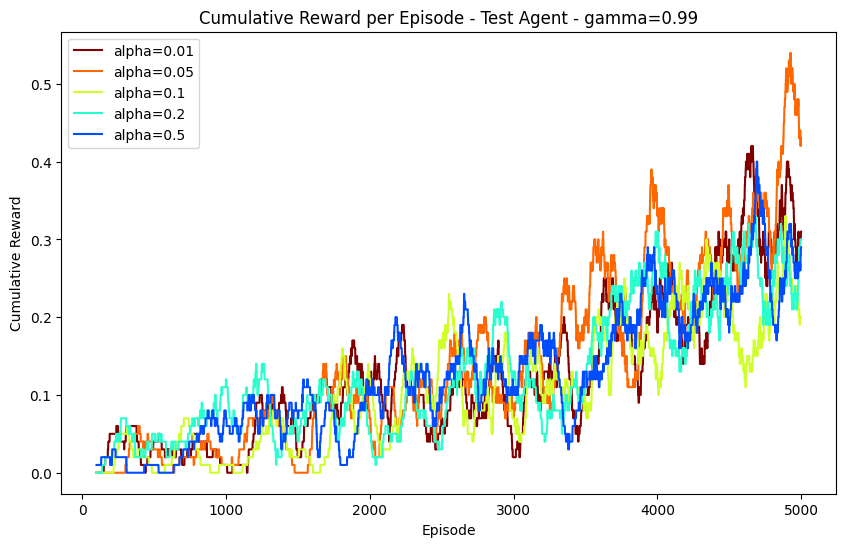

In [12]:
alphas = [.01, .05, .1, .2, .5]
N=len(alphas)

plt.figure(figsize=(10, 6))
i=0

for alpha in alphas:
      test_agent = Agent_Decay(env, gamma, alpha)
      rewards = run_experiment_episode_train(env, test_agent, nb_episode)
      window_size = 100
      moving_avg = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
      color = cmap(float(i)/N)
      i +=1
      plt.plot(range(window_size - 1, len(rewards)), moving_avg, label=f'alpha={alpha}', color=color)

plt.title(f'Cumulative Reward per Episode - Test Agent - gamma={gamma}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

In [27]:
nb_episode = 5000

test_agent_egreedy = Agent_epsilon_greedy(env, gamma=.99, epsilon=.05, alpha=.05)
test_agent_decay = Agent_Decay(env, gamma=.99, alpha=.05)

rewards_egreedy = run_experiment_episode_train(env, test_agent_egreedy, nb_episode)
rewards_decay = run_experiment_episode_train(env, test_agent_decay, nb_episode)

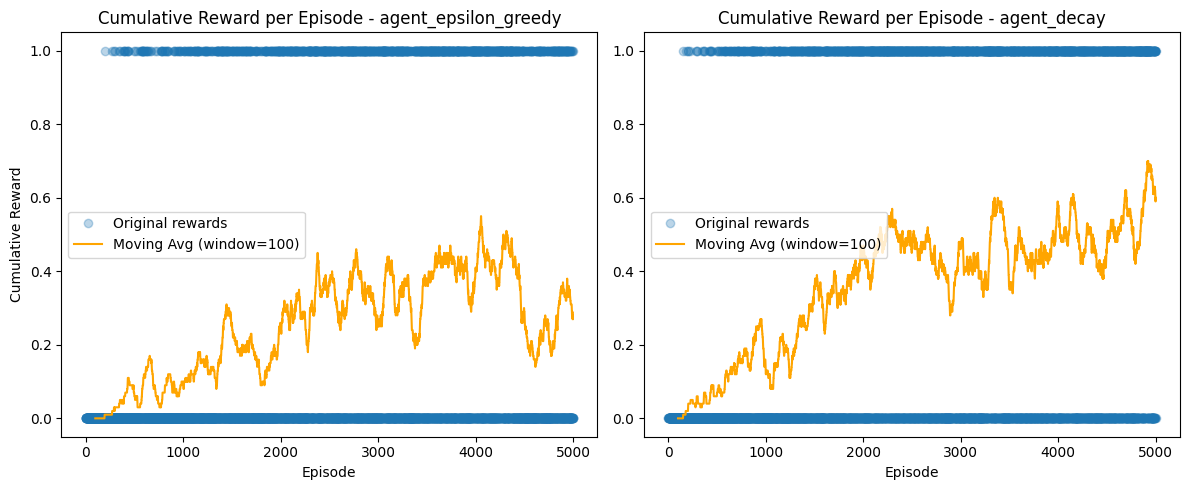

In [28]:
window_size = 100
moving_avg_egreedy = np.convolve(rewards_egreedy, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_decay, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(rewards_egreedy, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_egreedy)), moving_avg_egreedy, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_epsilon_greedy')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rewards_decay, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent_decay')
plt.xlabel('Episode')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
print(np.argmax(test_agent_egreedy.q, axis=1))

[2 2 2 2 2 1 2 1 3 3 3 3 2 2 2 1 2 2 0 0 2 3 2 1 3 3 0 1 0 0 2 2 0 3 3 0 2
 1 3 2 0 0 0 1 3 0 0 2 0 0 0 0 0 2 0 2 1 0 0 0 1 1 1 0]


### Before submit
Test that your agent has the right attributes

In [36]:
class Agent:
    def __init__(self, env):
        self.env = env
        self.policy = [2, 2, 2, 2, 2, 1, 2, 1, 3, 3, 3, 3, 2, 2, 2, 1, 2, 2, 0, 0, 2, 3, 2, 1, 3, 3, 0, 1, 0, 0, 2, 2, 0, 3, 3, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0]

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        action = self.policy[observation]
        return action

In [41]:
env = gym.make('FrozenLake-v1', map_name="8x8")
agent = Agent(env)

observation, _ = env.reset()
reward, terminated, truncated, info = None, False, False, None
rewards = []
while not (terminated or truncated):
    action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
print(f'Cumulative Reward: {sum(rewards)}')

Cumulative Reward: 0.0


In [40]:
nb_run = 10
rewards = []

for i in range(nb_run):
    observation, _ = env.reset()
    reward, terminated, truncated, info = None, False, False, None
    while not (terminated or truncated):
        action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
        observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
print(f'Mean Reward: {np.mean(rewards)}')

Mean Reward: 0.8
